In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from platform import python_version
import sklearn
from mitmproxy.tools.console.palettes import palettes
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier,AdaBoostClassifier
from sklearn.svm import NuSVC
from sklearn.tree import ExtraTreeClassifier
from sklearn.metrics import classification_report,accuracy_score,recall_score
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score

In [ ]:
library ={
    'Pandas': pd,
    'Matplotlib': matplotlib,
    'Seaborn': sns,
    'Numpy': np,
    'Scikit-Learn': sklearn
}
print('Library Version:\n')
print(f"{'':-^20}|{'':-^10}")
print(f"{'Library':^20}|{'Version':^10}")
print(f"{'':-^20}|{'':-^10}")

for name, lib in sorted(library.items()):
    print(f"{name:<20}l{lib.version :>10}")

print(f'\nPython Version: {python_version()}')

In [3]:
# 导入数据
df = pd.read_csv('./injury_data.csv')
df.head()

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury
0,24,66.251933,175.732429,1,0.457929,5,0
1,37,70.996271,174.581650,0,0.226522,6,1
2,32,80.093781,186.329618,0,0.613970,2,1
3,28,87.473271,175.504240,1,0.252858,4,1
4,25,84.659220,190.175012,0,0.577632,1,1


In [7]:
df['Player_Weight'] = df['Player_Weight'].round(2)
df['Player_Height'] = df['Player_Height'].round(2)
df['Training_Intensity'] = df['Training_Intensity'].round(2)
df.head()

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury
0,24,66.25,175.73,1,0.46,5,0
1,37,71.00,174.58,0,0.23,6,1
2,32,80.09,186.33,0,0.61,2,1
3,28,87.47,175.50,1,0.25,4,1
4,25,84.66,190.18,0,0.58,1,1


In [8]:
df_info = pd.DataFrame(df.dtypes, columns = ['Dtype'])
df_info['Unique'] = df.nunique().values
df_info['Null'] = df.isnull().sum().values
df_info

,Dtype,Unique,Null
Player_Age,int64,22,0
Player_Weight,float64,863,0
Player_Height,float64,875,0
Previous_Injuries,int64,2,0
Training_Intensity,float64,101,0
Recovery_Time,int64,6,0
Likelihood_of_Injury,int64,2,0


In [14]:
# df Describe 让计算结果保留两位小数
with pd.option_context(
    'display.float_format', '{:.2f}'.format, # 添加千分位分隔符
    'display.max_columns', None, # 显示所有列
    'display.precision', 2 # 双重确保小数精度
):
    display(df.describe())

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,28.23,74.79,179.75,0.52,0.49,3.47,0.50
std,6.54,9.89,9.89,0.50,0.29,1.70,0.50
min,18.00,40.19,145.29,0.00,0.00,1.00,0.00
25%,22.00,67.95,173.03,0.00,0.24,2.00,0.00
50%,28.00,75.02,180.03,1.00,0.48,4.00,0.50
75%,34.00,81.30,186.56,1.00,0.73,5.00,1.00
max,39.00,104.65,207.31,1.00,1.00,6.00,1.00


In [ ]:
# 创建新列, 一列为BMI, 林外一列年龄类别
# BMI是一种用来评估一个人的体重与身高之间的关系是否健康的指标: 体重(千克)/(身高(米))²
# 在现实生活中 BMI 并不是评估运动员是否健康的最佳身体状态的最佳指标, 因为这个指标并没有考虑到运动员的身体组成,
# 比如强健的肌肉, 肌肉质量, 骨密度等, 都有可能被评估为超重

In [15]:
# 创建一列来计算BMI
df['BMI'] = df['Player_Weight']/(df['Player_Height']/100**2)

# 将BMI进行归类
gaps = [-float('inf'), 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')]
categories = ['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III']

# 创建BMI的分类列 ('BMI_classification')
df['BMI_Classification'] = pd.cut(df['BMI'], bins= gaps, labels= categories, right= False)
df.head()

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury,BMI,BMI_Classification
0,24,66.25,175.73,1,0.46,5,0,3769.988050,Obesity III
1,37,71.00,174.58,0,0.23,6,1,4066.903425,Obesity III
2,32,80.09,186.33,0,0.61,2,1,4298.287984,Obesity III
3,28,87.47,175.50,1,0.25,4,1,4984.045584,Obesity III
4,25,84.66,190.18,0,0.58,1,1,4451.572195,Obesity III


In [16]:
# 找出数据集中运动员的最小的年龄和最大的年龄
print('最小的年龄为: {}岁, 最大的年龄为: {}岁'.format(df['Player_Age'].min(), df['Player_Age'].max()))

最小的年龄为: 18岁, 最大的年龄为: 39岁


In [18]:
# 创建年龄分组列
df['Age_Group'] = pd.cut(df['Player_Age'], bins=[18, 22, 26, 30, 34, df['Player_Age'].max()],
                         labels=['18-22', '22-26', '26-30', '30-34', '35+'], include_lowest= True)
df.head()

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury,BMI,BMI_Classification,Age_Group
0,24,66.25,175.73,1,0.46,5,0,3769.988050,Obesity III,22-26
1,37,71.00,174.58,0,0.23,6,1,4066.903425,Obesity III,35+
2,32,80.09,186.33,0,0.61,2,1,4298.287984,Obesity III,30-34
3,28,87.47,175.50,1,0.25,4,1,4984.045584,Obesity III,26-30
4,25,84.66,190.18,0,0.58,1,1,4451.572195,Obesity III,22-26


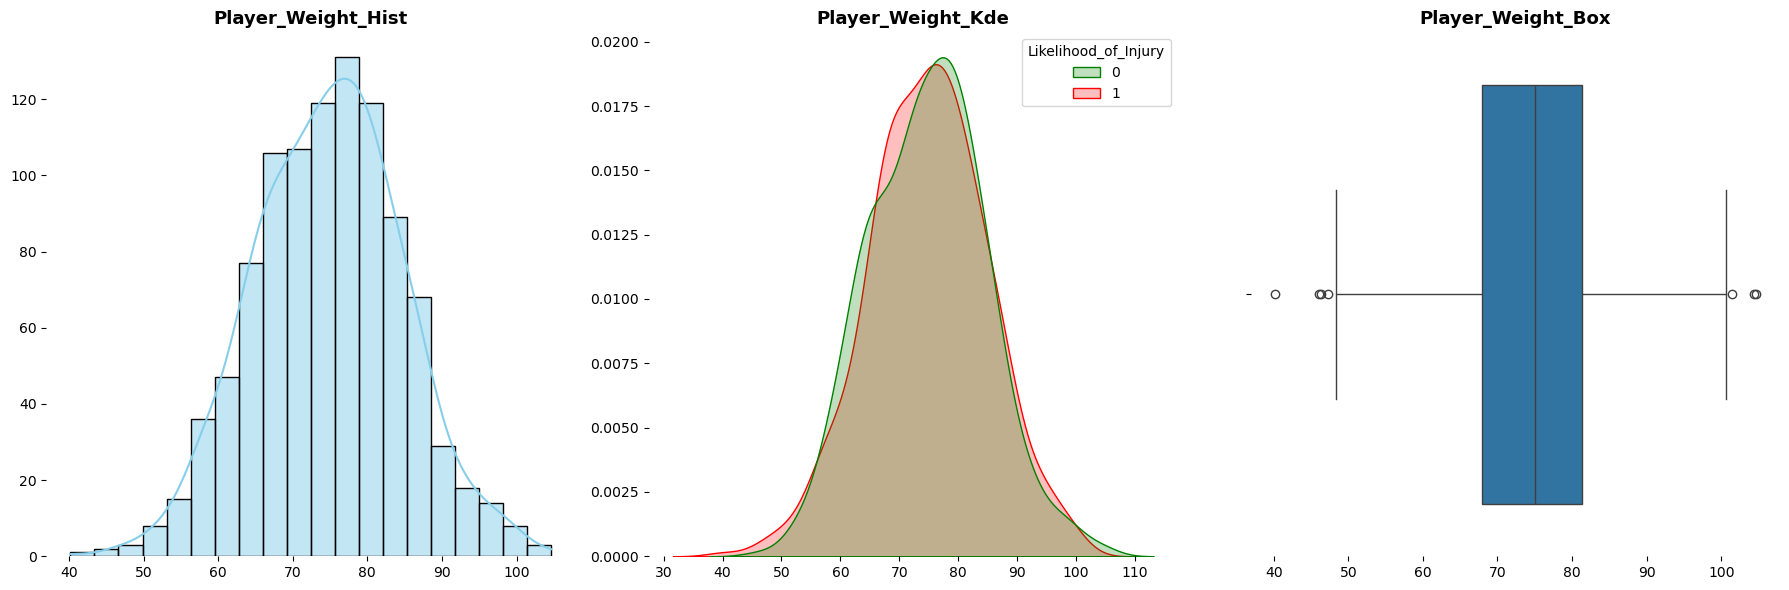

In [25]:
# 数据的探索性分析, 因为数据集中只有很少的列, 所以我们可以分析所有的列
def plot_hist_kde_boxplot(dataframe, column, color_column):
    fit, axs = plt.subplots(1,3,figsize=(18, 6))

    # 移除grid 和 spines
    for ax in axs:
        ax.grid(False)
        for spine in ax.spines.values():
            spine.set_visible(False)

    # 直方图
    sns.histplot(data = dataframe, x= column, bins = 20, color='skyblue',
                 edgecolor= 'black', kde=True, ax=axs[0])
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')
    axs[0].set_title(f'{column}_Hist', weight='bold', size=13)

    #kde图 (密度图)
    sns.kdeplot(data= dataframe, x=column, color='skyblue', fill= True, hue= color_column,
               palette = {0: 'green', 1: 'red'}, ax= axs[1])
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
    axs[1].set_title(f'{column}_Kde', weight='bold', size=13)

    #箱型图
    sns.boxplot(data= dataframe[column], orient='h', ax=axs[2])
    axs[2].set_xlabel('')
    axs[2].set_ylabel('')
    axs[2].set_title(f'{column}_Box', weight='bold', size=13)

    plt.tight_layout()
    plt.show()

plot_hist_kde_boxplot(df, 'Player_Weight', 'Likelihood_of_Injury')

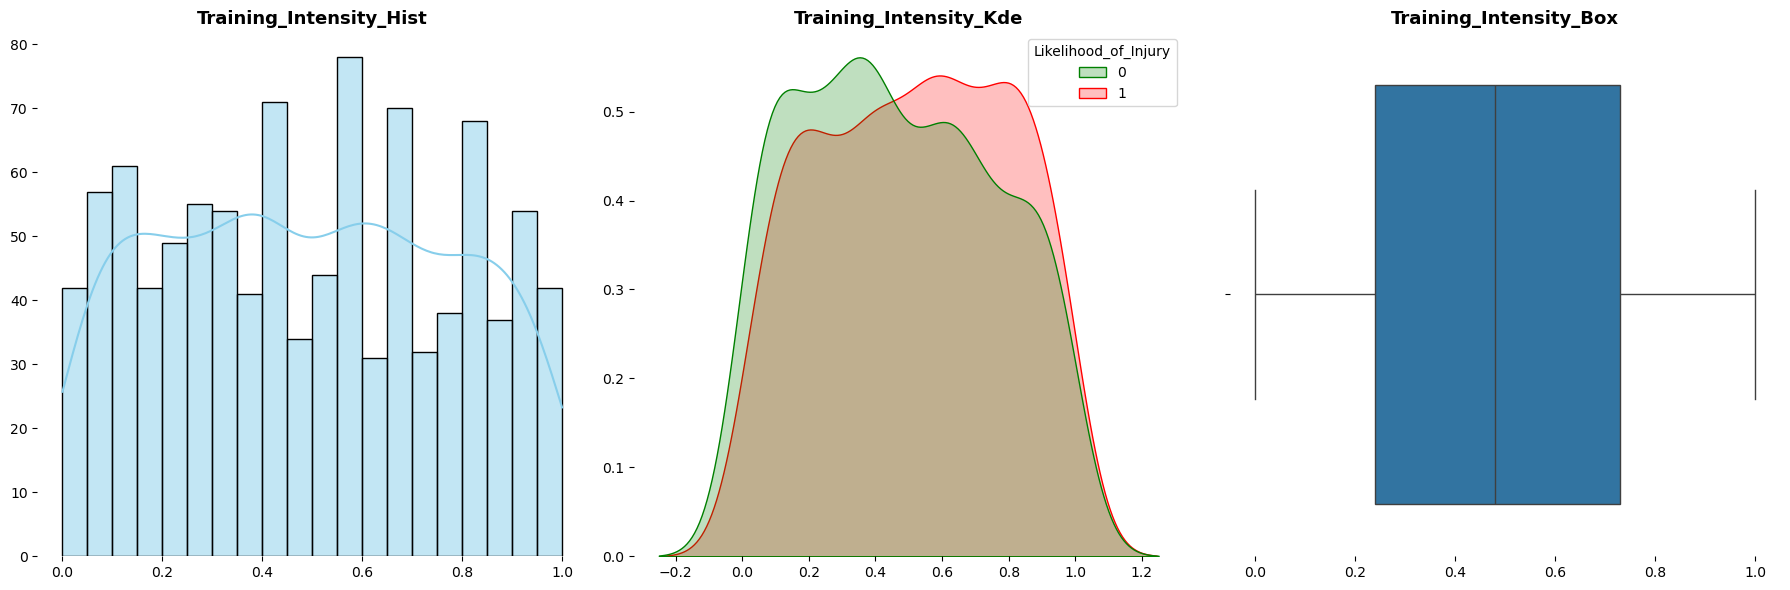

In [26]:
plot_hist_kde_boxplot(df, 'Training_Intensity', 'Likelihood_of_Injury')

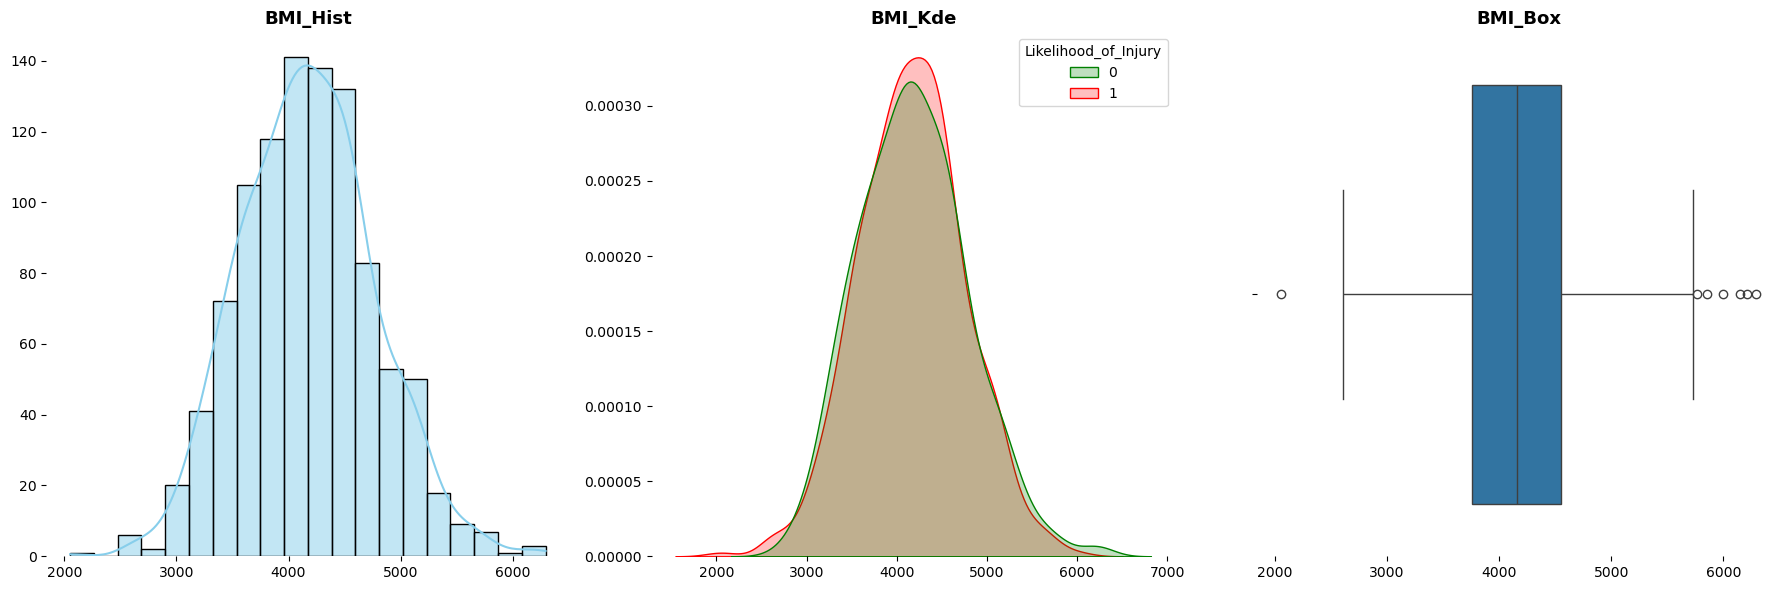

In [27]:
plot_hist_kde_boxplot(df, 'BMI', 'Likelihood_of_Injury')

In [33]:
one_hot_cols = ['BMI_Classification', 'Age_Group']
df_categorical = df[one_hot_cols]

encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df_categorical)

# 获取OneHotEncoder生成的特征名称
one_hot_feature_names = encoder.get_feature_names_out(one_hot_cols)

# 传教一个 dataFrame
df_encoded = pd.DataFrame(encoded_data.toarray(), columns = one_hot_feature_names)

df_final = pd.concat([df, df_encoded], axis = 1)

df_final.drop(columns = ['BMI_Classification', 'Age_Group'], inplace = True)

df_final.head()

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury,BMI,BMI_Classification_Obesity III,Age_Group_18-22,Age_Group_22-26,Age_Group_26-30,Age_Group_30-34,Age_Group_35+
0,24,66.25,175.73,1,0.46,5,0,3769.988050,1.0,0.0,1.0,0.0,0.0,0.0
1,37,71.00,174.58,0,0.23,6,1,4066.903425,1.0,0.0,0.0,0.0,0.0,1.0
2,32,80.09,186.33,0,0.61,2,1,4298.287984,1.0,0.0,0.0,0.0,1.0,0.0
3,28,87.47,175.50,1,0.25,4,1,4984.045584,1.0,0.0,0.0,1.0,0.0,0.0
4,25,84.66,190.18,0,0.58,1,1,4451.572195,1.0,0.0,1.0,0.0,0.0,0.0


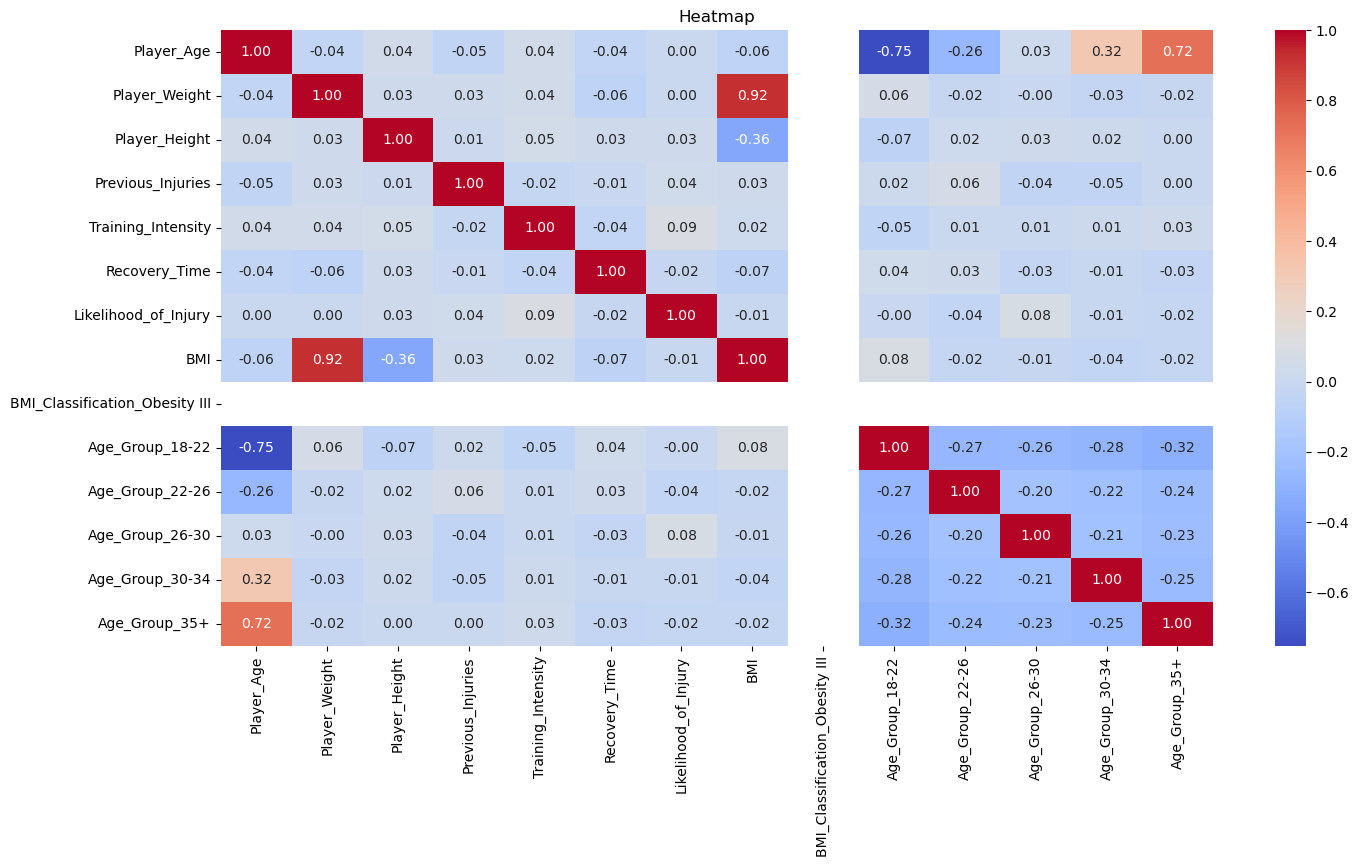

In [34]:
# 通过热力图查看列之间的相关性
correlation_matrix = df_final.corr()

# 绘制热力图
plt.figure(figsize= (16, 8))
sns.heatmap(correlation_matrix, annot= True, cmap='coolwarm', fmt='.2f' )
plt.title('Heatmap')
plt.show()

C:\Users\dongz\AppData\Local\Temp\ipykernel_11172\4177125370.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= correlation_with_likelihood.index, y= correlation_with_likelihood.values, palette = 'coolwarm', legend = False)


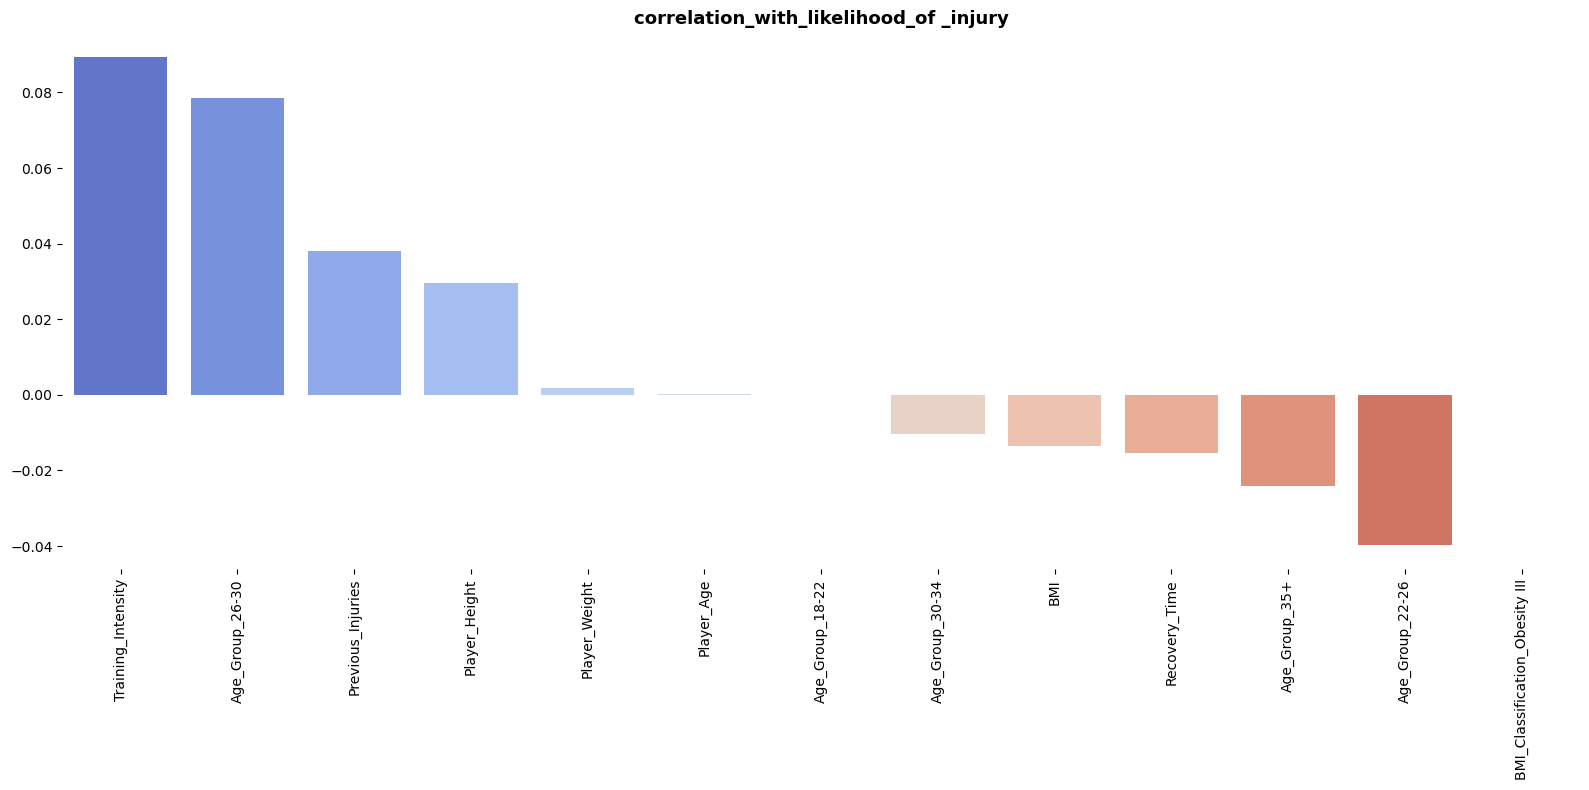

In [40]:
# 仅从相关矩阵中选择"受伤可能性"的相关列
correlation_with_likelihood = correlation_matrix['Likelihood_of_Injury']
# 删除受伤可能性的相关性
correlation_with_likelihood = correlation_with_likelihood.drop('Likelihood_of_Injury')
# 按降序排列相关性
correlation_with_likelihood = correlation_with_likelihood.sort_values(ascending = False)
# 绘制相关条形图
plt.figure(figsize = (16, 8))
sns.barplot(x= correlation_with_likelihood.index, y= correlation_with_likelihood.values, palette = 'coolwarm', legend = False)
plt.xticks(rotation = 90, ha = 'center')
plt.xlabel('')
plt.ylabel('')
plt.box(False)
plt.title('correlation_with_likelihood_of _injury', weight = 'bold', size= 13)
plt.tight_layout()
plt.show()

In [41]:
# 排除 Age_group 列
df_final = df_final.loc[:, ~df_final.columns.str.startswith('Age_Group')]
# 排除BMI项
df_final = df_final.drop(columns = ['BMI'])
df_final.head(1)

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury,BMI_Classification_Obesity III
0,24,66.25,175.73,1,0.46,5,0,1.0


### 训练模型

In [44]:
## 特征
X = df_final.drop('Likelihood_of_Injury', axis = 1)
# 目标变量
y = df_final['Likelihood_of_Injury']

# 将数据分为训练集和测试集
X_trian, X_test, y_trian, y_test = train_test_split(X, y, test_size=0.2, random_state= 43)

In [46]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

In [47]:
# 字典模型
models = {'AdaBoostClassifier': AdaBoostClassifier(),
          'ExtraTreesClassifier': ExtraTreesClassifier(),
          'NuSVC': NuSVC(probability= True),
          }

for model_name, model in models.items():
    model.fit(X_trian, y_trian)
    predictions = model.predict(X_test)
    recall = recall_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)

    print(f'Model:{model_name}')
    print(f'Recall:{recall}')
    print(f'Accuracy:{accuracy}')
    print(f'Precision:{precision}')
    print('-'*50)


Model:AdaBoostClassifier
Recall:0.46601941747572817
Accuracy:0.5
Precision:0.5161290322580645
--------------------------------------------------
Model:ExtraTreesClassifier
Recall:0.5339805825242718
Accuracy:0.54
Precision:0.5555555555555556
--------------------------------------------------
Model:NuSVC
Recall:0.5825242718446602
Accuracy:0.48
Precision:0.49586776859504134
--------------------------------------------------


## 模型算着

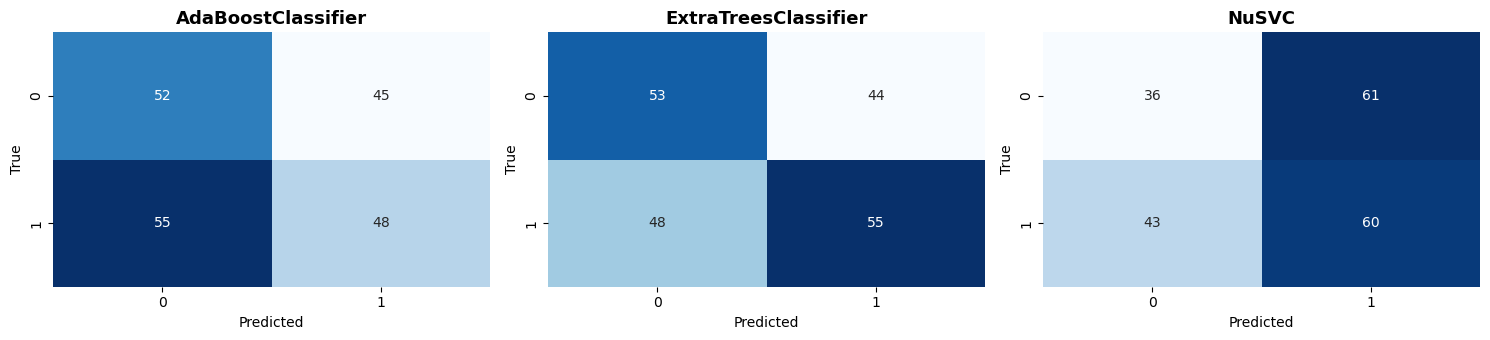

In [50]:
fig,axes=plt.subplots(1,len(models),figsize =(15,3.5))

for ax,(model_name,model)in zip(axes,models.items()):
    #给每个模型绘制混淆矩阵
    predictions = model.predict(X_test)
    cm =confusion_matrix(y_test,predictions)
    sns.heatmap(cm,annot = True,fmt = 'd',cmap ='Blues',cbar = False,ax = ax)
    ax.set_title(f'{model_name}',weight ='bold',size = 13)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
plt.tight_layout()
plt.show()